In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(10,6)})

model_name = 'decayed_model'

In [2]:
losses = torch.load(f'saved_model_params/refined_model/{model_name}_losses.pt')
print(losses)

[3.6365713278452554, 0.6811892688274384, 0.2503027319908142, 0.22900660584370294, 0.15408621107538542, 0.1517493724822998, 0.13248074489335218, 0.12649034087856612, 0.12956453238924345, 0.12057716151078542, 0.12701277062296867, 0.11940410609046619, 0.12263518571853638, 0.11865999922156334, 0.11876157174507777, 0.11533852914969127, 0.1161331757903099, 0.11388623714447021, 0.11392032727599144, 0.11276942615707715, 0.11282293995221455, 0.1118118775387605, 0.11127266536156337, 0.11066903546452522, 0.11040039981404941, 0.1097754891961813, 0.11012717274328072, 0.10926730992893378, 0.10771390857795875, 0.10813388352592786, 0.10677699061731498, 0.10671851101020972, 0.10618402001758416, 0.10681166872382164, 0.10388296904663245, 0.10459007074435551, 0.10329743412633736, 0.10302153167625268, 0.10526380501687527, 0.10311597088972728, 0.10525654753049214, 0.09901195019483566, 0.09931937977671623, 0.09924882153669994, 0.09841723491748174, 0.0984376072883606, 0.0942683977385362, 0.0947142168879509, 0

Text(0, 0.5, 'Loss')

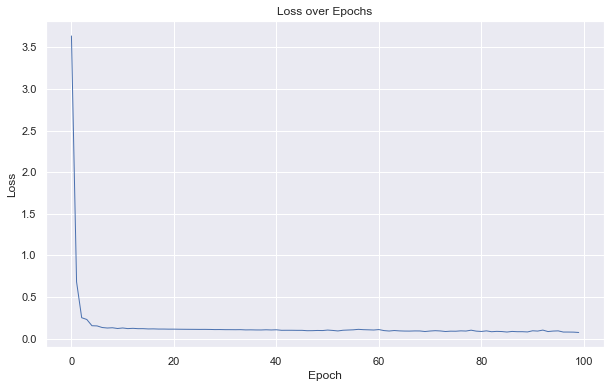

In [3]:
ax = sns.lineplot(losses, linewidth=1)
ax.set_title('Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')


# Model Performance Visualizations

In [4]:
# Setup Model
from models.refined_model import GCN as GCN_Refined
from models.model import GCN

# model = GCN()
model = GCN_Refined(
    input_channels=2, output_channels=1, hidden_channels=8, num_hidden=4
)
model.load_state_dict(torch.load(f"saved_model_params/refined_model/{model_name}.pt"))
model = model.eval()
print(model)

GCN(
  (gconv_layers): ModuleList(
    (0): SAGEConv(2, 8, aggr=mean)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): SAGEConv(8, 8, aggr=mean)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SAGEConv(8, 8, aggr=mean)
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SAGEConv(8, 8, aggr=mean)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): SAGEConv(8, 8, aggr=mean)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [5]:
data = torch.load("datasets/low_range/SG256_0_SM_5_Test.pt")

y_truth = np.array([])
y_pred = np.array([])
dm_mass = np.array([])
redshift = np.array([])
for graph in data:
    graph.x = torch.tensor([[data[0], data[1]] for data in graph.x])

    # Logspace calcs
    graph.y = torch.log10(graph.y)
    graph.x[:, 0] = torch.log10(graph.x[:, 0])

    for item in graph.y:
        y_truth = np.append(y_truth, item)

    for item in graph.x:
        dm_mass = np.append(dm_mass, item[0])
        redshift = np.append(redshift, item[1])

    out = model(graph)
    for item in out.tolist():
        y_pred = np.append(y_pred, item[0])

# unlogspace
# y_truth = 10 ** y_truth
# y_pred = 10 ** y_pred

print(len(y_pred), "total halo snapshots")
print(len(data), "graphs")

3694 total halo snapshots
11 graphs


In [12]:
import scipy.stats
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import r2_score


def create_hexplot(
    x_bins: int,
    y_bins: int,
    x: any,
    y: any,
    x_label: str,
    y_label: str,
    title: str,
    display_stats: bool,
    display_yeqx: bool,
    median_std_overlay: bool = True,
    reverse_x: bool = False,
    file_name: str = None,
):
    # Create hexbin plot with custom color palette
    g = sns.color_palette(["lightgray", "darkgray", "black"])
    cmap_g = LinearSegmentedColormap.from_list("custom_gray_to_black", g)
    plt.hexbin(x, y, gridsize=(x_bins, y_bins), cmap=cmap_g, mincnt=1)

    # Create mean/std overlay
    if median_std_overlay:
        # Calculate median and standard deviation of Y values for each X bin
        x_bins_edges = np.linspace(min(x), max(x), x_bins + 1)
        y_median = [
            np.median(y[(x >= x_bins_edges[i]) & (x < x_bins_edges[i + 1])])
            for i in range(x_bins)
        ]
        y_std = [
            np.std(y[(x >= x_bins_edges[i]) & (x < x_bins_edges[i + 1])])
            for i in range(x_bins)
        ]
        x_bins_centers = 0.5 * (x_bins_edges[:-1] + x_bins_edges[1:])

        # Plot median and standard deviation as continuous functions
        plt.plot(x_bins_centers, y_median, color="turquoise", label="Median of Y")
        plt.fill_between(
            x_bins_centers,
            np.array(y_median) - np.array(y_std),
            np.array(y_median) + np.array(y_std),
            color="turquoise",
            alpha=0.3,
            label="Std Dev of Y",
        )
        if not display_yeqx:
            plt.legend(
                [f"Median of {y_label}"],
                loc="upper right",
                fontsize=22,
            )

    # Title
    plt.title(title, fontsize=26, pad=20)

    # Create colorbar
    cbar = plt.colorbar()
    cbar.set_label("Number of Halo Snapshots", fontsize=18)
    cbar.ax.tick_params(labelsize=22)

    # Label axes
    plt.xlabel(x_label, fontsize=22, labelpad=15)
    if reverse_x:
        plt.gca().invert_xaxis()
    plt.ylabel(y_label, fontsize=22, labelpad=15)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Plot perfect predictions line y=x
    if display_yeqx:
        plt.plot([2, 5], [2, 5], ls="--", c="0")
        plt.legend(["Perfect Predictions"], loc="lower right", fontsize=14)
        if median_std_overlay:
            plt.legend(
                [f"Median of {y_label}", "Perfect Predictions"],
                loc="upper right",
                fontsize=22,
            )
        else:
            plt.legend(["Perfect Predictions"], loc="upper right", fontsize=14)

    plt.tight_layout()
    if file_name is not None:
        plt.savefig(
            f"./images/{file_name}.pdf",
            dpi=300,
            bbox_inches="tight",
            pad_inches=0.1,
        )
    plt.show()

    if display_stats:
        residuals = x - y
        print(f"Pearson correlation: {scipy.stats.pearsonr(x, y)}")
        print(f"MSE:  {np.mean(residuals**2)}")
        print(f"Mean absolute error: {np.mean(np.abs(residuals))} dex")
        print(f"Scatter: {scipy.stats.tstd(residuals)} dex")
        print(f"Bias: {np.mean(residuals)} dex")
        print(f"R^2: {r2_score(y_true=x, y_pred=y)}")

c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

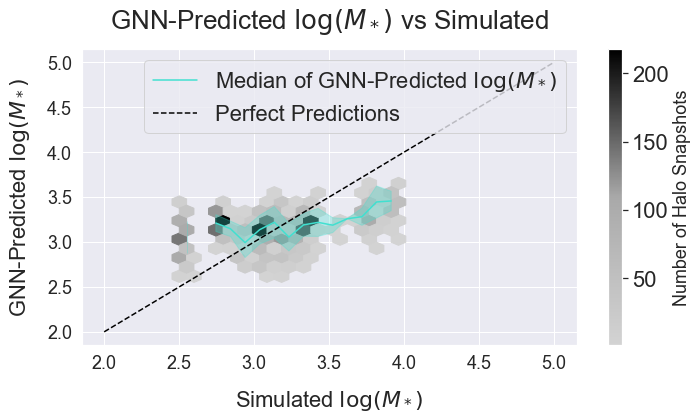

Pearson correlation: (0.42531753028826275, 3.2650763611364264e-162)
MSE:  0.1345618637699548
Mean absolute error: 0.30527371306902146 dex
Scatter: 0.3621268838977241 dex
Bias: -0.058834372821471206 dex
R^2: 0.15838021428632898


In [13]:
create_hexplot(15, 5, y_truth, y_pred, "Simulated $\log(M_*)$", "GNN-Predicted $\log(M_*)$", "GNN-Predicted $\log(M_*)$ vs Simulated", True, True)

c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

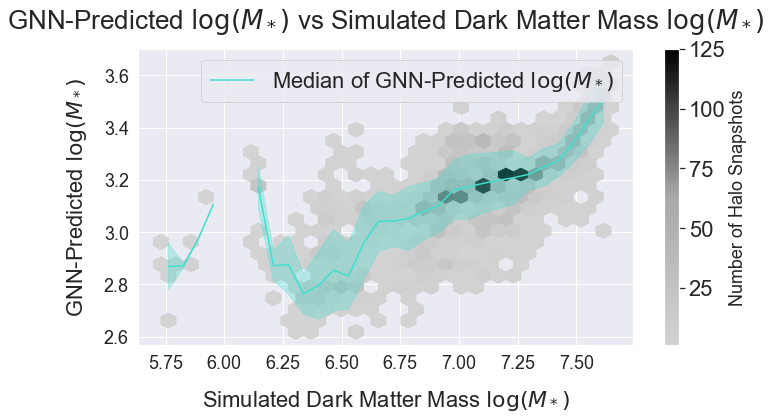

In [14]:
create_hexplot(30, 12, dm_mass, y_pred, "Simulated Dark Matter Mass $\log(M_*)$", "GNN-Predicted $\log(M_*)$", "GNN-Predicted $\log(M_*)$ vs Simulated Dark Matter Mass $\log(M_*)$", False, False)

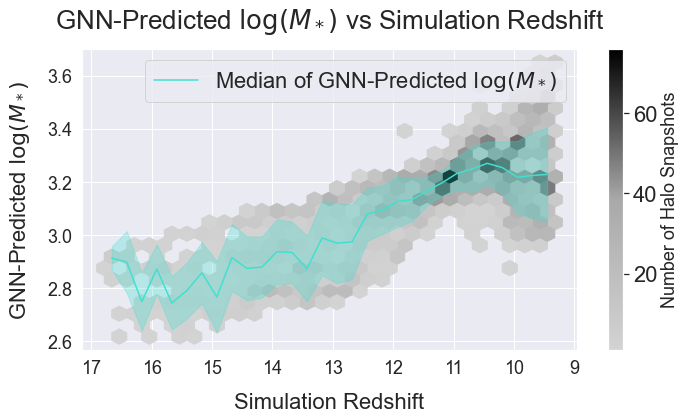

In [15]:
create_hexplot(30, 12, redshift, y_pred, "Simulation Redshift", "GNN-Predicted $\log(M_*)$", "GNN-Predicted $\log(M_*)$ vs Simulation Redshift", False, False, True, True)

c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\Vince\anaconda3\envs\wise_group_galaxy_pred\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

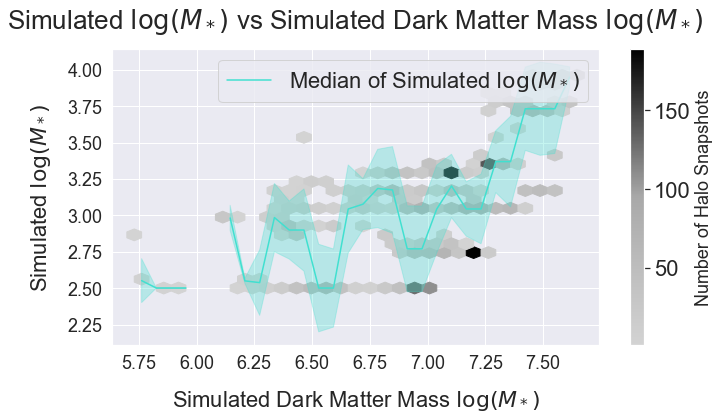

In [16]:
create_hexplot(30, 12, dm_mass, y_truth, "Simulated Dark Matter Mass $\log(M_*)$", "Simulated $\log(M_*)$", "Simulated $\log(M_*)$ vs Simulated Dark Matter Mass $\log(M_*)$", False, False)

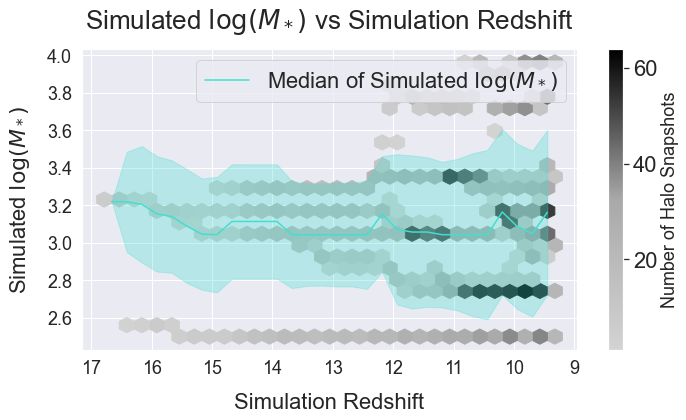

In [17]:
create_hexplot(30, 12, redshift, y_truth, "Simulation Redshift", "Simulated $\log(M_*)$", "Simulated $\log(M_*)$ vs Simulation Redshift", False, False, True, True)